# Investigating medical appointment records in Brazil focused on whether the patient showed up for their appointment or not

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and 14 associated variables (characteristics). It is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

<ul>
    <li>PatientId: Identification of a patient</li>
    <li>AppointmentID: Identification of each appointment</li>
    <li>Gender: Male or Female . Female is the greater proportion, women take way more care of they health in comparison to man.</li>
    <li>ScheduledDay: The day of the actuall appointment, when they have to visit the doctor.</li>
    <li>AppointmentDay: The day someone called or registered the appointment, this is before appointment of course.</li>
    <li>Age: How old is the patient.</li>
    <li>Neighbourhood: Where the appointment takes place.</li>
    <li>Scholarship: True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia	</li>
    <li>Hipertension: True or False.</li>
    <li>Diabetes: True or False.</li>
    <li>Alcoholism: True or False.</li>
    <li>Handcap: True or False.</li>
    <li>SMS_received: True or False: 1 or more messages sent to the patient.</li>
    <li>No-show> True (Did not show up) or False (Showed up). </li
</ul>

In [1]:
# Importing all the necessary packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

%matplotlib inline

### Potential Research Questions
<ol>
    <li> What neighborhoods have the most absences?</li>
    <li> What days were the most appointments missed?</li>
    <li> Which age groups (Young, Adults, etc.) have the most absences?</li>
    <li> Are people who receive SMS are more or less absent than the ones who do not?</li>
    <li> Which characteristics affect the likelihood of absence the most? By how much?</li>
</ol>

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Loading dataset
df = pd.read_csv("noshowappointments2016.csv")

# Taking a look at the first five rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Comments
From the first glance, there are few things that will need to be handled:
<ul> 
    <li> The dates look like in a very detailed format so they will need to be extracted/converted </li>
    <li> The No-shows are in Yes/No string format and will need to be converted to a numerical value </li>
    <li> The Age should be encoded to 1(Male) and 0(Female) so it is easier to analyze and manipulate </li>
</ul>

In [3]:
# Checking the data types to see if there are some potentially tricky datatypes that we will need to convert
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

#### Comments
Regarding the data types:
<ul> 
    <li> The dates are in a string format so to extract them to a YYYY-MM-DD format, we will convert them to date format so we can use date manipulation functions </li>
    <li> The No-shows are in the string format and will need to be converted to integer format</li>
</ul>

In [4]:
# Looking at the number of null values to see if we are going to need to replace them
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [5]:
# Looking at the number of duplicate values to see if we are going to need to replace them
df.duplicated().sum()

0

### General Properties: Conclusion
#### From a brief analysis of the properties, we can conclude that:
<ol>
<li>The dates will have to be converted to a more analysis friendly format and data type preferably on a day (Monday = 1, Tuesday = 2, ...) format</li>
<li>The no/show is confusing and in the string data type. We will rename the column name to Absent and convert the values to 1 and 0 so they are easier to plot</li>
<li>The ages will have to be put into bins, otherwise the plotting will be messy with such a wide distribution</li>
<li> There are not any null or duplicate values in this dataset, making our job simpler </li>
</ol>

### Research Questions
#### The questions that we are going to answer are:
<ol>  
 <li> What neighborhoods have the most absences? </li>  
 <li> What days were the most appointments missed? </li>  
 <li> Which age groups (Young, Adults, etc.) have the most absences? </li>  
 <li> Are people who receive SMS are more or less absent than the ones who do not? </li>  
 <li> Which characteristics affect the likelihood of absence the most? By how much? </li>
</ol>  

### Data Cleaning

In [6]:
# Converting dates. Rather than analyzing full date to the last second, what will be more useful for this analysis is to extract
# year, month and day and create a separate columns day of the week to see whether there are patterns

# Before we start with cleaning, lets create a copy of our original dataset
df1 = df.copy()

# Converting Scheduled Day and Appointment Day to a datetime data type and extracting it into YYYY-MM-DD format
df1["ScheduledDay"] = pd.to_datetime(df1["ScheduledDay"])
df1["AppointmentDay"] = pd.to_datetime(df1["AppointmentDay"])

# Extracting day of the week from the dates and creating a new columns out of it
df1["ScheduledDayOfWeek"] = df1["ScheduledDay"].dt.dayofweek
df1["AppointmentDayOfWeek"] = df1["AppointmentDay"].dt.dayofweek
df1.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayOfWeek,AppointmentDayOfWeek
110522,2.572130e+12,5651768,F,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No,1,1
110523,3.596270e+12,5650093,F,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No,1,1
110524,1.557660e+13,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,2,1
110525,9.213490e+13,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,2,1
110526,3.775120e+14,5629448,F,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No,2,1


In [8]:
# Changing column name from No-show to Absent
df1.rename(columns={"No-show":"Absent"}, inplace=True)
df1.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Absent,ScheduledDayOfWeek,AppointmentDayOfWeek
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4
1,5.589980e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4
2,4.262960e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4
3,8.679510e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4
4,8.841190e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4


In [9]:
# Checking value count of Absent col
df1.Absent.value_counts()

No     88208
Yes    22319
Name: Absent, dtype: int64

In [10]:
# Changing values to numerical. Yes = 1, No = 0
df1 = df1.replace({'Absent': {'Yes': 1, 'No': 0}})
df1.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Absent,ScheduledDayOfWeek,AppointmentDayOfWeek
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,4,4
1,5.589980e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,4,4
2,4.262960e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,4,4
3,8.679510e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,4,4
4,8.841190e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,4,4


In [11]:
# Double checking whether the value count remains the same after converting the Absent column
df1.Absent.value_counts()

0    88208
1    22319
Name: Absent, dtype: int64

In [12]:
# Checking value count of Gender col
df1.Gender.value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [13]:
# Converting Gender to binary values
df1 = df1.replace({'Gender': {'M': 1, 'F': 0}})
df1.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Absent,ScheduledDayOfWeek,AppointmentDayOfWeek
110522,2.572130e+12,5651768,0,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,1,1
110523,3.596270e+12,5650093,0,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,1,1
110524,1.557660e+13,5630692,0,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,2,1
110525,9.213490e+13,5630323,0,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,2,1
110526,3.775120e+14,5629448,0,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,0,2,1


In [14]:
# Double checking whether the value count remains the same after converting the Gender column
df1.Gender.value_counts()

0    71840
1    38687
Name: Gender, dtype: int64

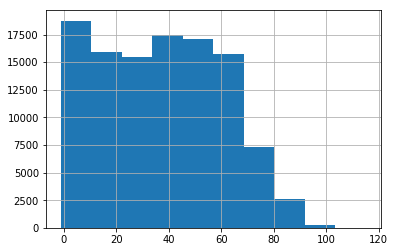

In [15]:
# Taking a look at the age distribution.
df1.Age.hist()

# Creating age bins and labels
bins = [0,18,36,54,72,115]
labels = ["0-18", "19-36", "37-54", "55-72", "73+"]

In [16]:
# Creating a new col Age_Group with the age classificaiton based on the bins and labels we created
df1['Age_Group'] = pd.cut(df1['Age'], bins,labels=labels)

#Double checking whether we missed some age records
df1.isnull().sum()

PatientId                  0
AppointmentID              0
Gender                     0
ScheduledDay               0
AppointmentDay             0
Age                        0
Neighbourhood              0
Scholarship                0
Hipertension               0
Diabetes                   0
Alcoholism                 0
Handcap                    0
SMS_received               0
Absent                     0
ScheduledDayOfWeek         0
AppointmentDayOfWeek       0
Age_Group               3540
dtype: int64

#### Comments
3540 Age records were not classified.
One possible explanation why so many values have not been classified is that there are either negative age values or children below 1 year.

In [17]:
# Lets take a look at the values
queryNull = df1.query("Age < 1")
queryNull.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Absent,ScheduledDayOfWeek,AppointmentDayOfWeek,Age_Group
59,7.184430e+13,5638545,0,2016-04-29 08:08:43,2016-04-29,0,CONQUISTA,0,0,0,0,0,0,0,4,4,NaN
63,2.366230e+14,5628286,1,2016-04-27 10:46:12,2016-04-29,0,SÃO BENEDITO,0,0,0,0,0,0,0,2,4,NaN
64,1.885170e+14,5616082,1,2016-04-25 13:28:21,2016-04-29,0,ILHA DAS CAIEIRAS,0,0,0,0,0,1,0,0,4,NaN
65,2.718820e+14,5628321,1,2016-04-27 10:48:50,2016-04-29,0,CONQUISTA,0,0,0,0,0,0,0,2,4,NaN
67,8.647130e+13,5639264,0,2016-04-29 08:53:02,2016-04-29,0,NOVA PALESTINA,0,0,0,0,0,0,0,4,4,NaN


#### Comments
Since there are so many records of "0" age, we can assume that it is not a mistake and we are talking about babies younger than 1 year.

In [18]:
# Adjusting the bins so it includes 0 Age
bins = [-0.00001,18,36,54,72,115]
labels = ["0-18", "19-36", "37-54", "55-72", "73+"]
df1['Age_Group'] = pd.cut(df1['Age'], bins,labels=labels)
df1.isnull().sum()

PatientId               0
AppointmentID           0
Gender                  0
ScheduledDay            0
AppointmentDay          0
Age                     0
Neighbourhood           0
Scholarship             0
Hipertension            0
Diabetes                0
Alcoholism              0
Handcap                 0
SMS_received            0
Absent                  0
ScheduledDayOfWeek      0
AppointmentDayOfWeek    0
Age_Group               1
dtype: int64

In [19]:
# It seems there is one value that has not been classified. Lets take a look how it looks like
# For negative values, there is only one, which is - 1. Since it is only 1 entry, it is most likely a mistake so I will drop it
queryNull = df1.query("Age < 0")
df1.drop(df1.index[99832],inplace=True)
df1.isnull().sum()

PatientId               0
AppointmentID           0
Gender                  0
ScheduledDay            0
AppointmentDay          0
Age                     0
Neighbourhood           0
Scholarship             0
Hipertension            0
Diabetes                0
Alcoholism              0
Handcap                 0
SMS_received            0
Absent                  0
ScheduledDayOfWeek      0
AppointmentDayOfWeek    0
Age_Group               0
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (What are neighborhoods with the most absentees?)

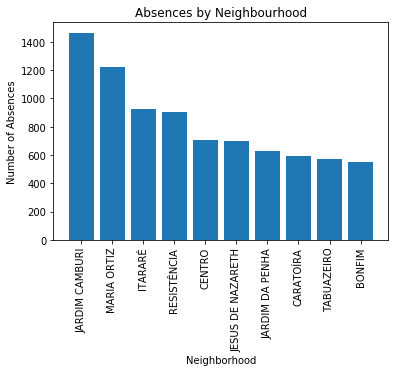

In [20]:
# Filtering dataset to the people with Absences
absentdf = df1.query('Absent == 1')

# Aggregating to a list of 10 neighbourhoods with the most absences
absentByNeighbourhood = absentdf.groupby("Neighbourhood")["Neighbourhood"].count().nlargest(10)

# Creating a function generate_labels that will create a labels from an aggregated list of values
# Input: aggregated(grouped) dataframe
# Output: list of labels
def generate_labels(aggregated_dataframe):
    return aggregated_dataframe.index.tolist()

# Creating a bar chart
locations = [1,2,3,4,5,6,7,8,9,10]
heights = absentByNeighbourhood.values.tolist()
# Need to list the labels and rename the title, xlabel, ylabel
labels = generate_labels(absentByNeighbourhood)

plt.bar(locations, heights, tick_label=labels)
plt.xticks(rotation=90)
plt.title('Absences by Neighbourhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Absences');

#### Comments
The neighbourhood with the most absences are Jardum Camburi followed by Maria Ortiz and Itararé. A good future potential research question would be to identify if there are common variables that these neighborhoods share (Unemployment rate, Income, # of hospitals per capita, etc.). Limitation: We have to keep in mind, that all these neighbourhoods also have the most data points in this dataset so the results might be skewed in that regards. We cannot make a fair comparison there since the range of the data points is from 0 to hundreds with a differing distribution across other variables (Age, Gender, etc.)

### Research Question 2  (What days were the most appointments missed?)

Text(0.5, 0, 'Number of absences')

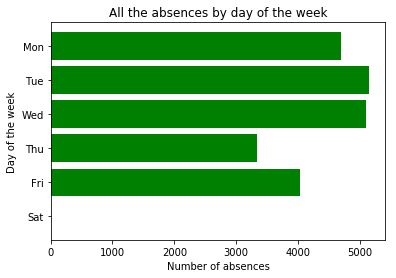

In [24]:
# Aggreggating all the absentees by Day of Week
absentByDays = absentdf.groupby("AppointmentDayOfWeek")["AppointmentDayOfWeek"].count()              
               
# Creating a horizontal bar chart to visualise the absences by day
w = ["Sat", "Fri", "Thu", "Wed", "Tue", "Mon"]
c = absentByDays.values.tolist()
c.reverse()

plt.barh(w, c, align='center', color="green")
plt.title("All the absences by day of the week")
plt.ylabel("Day of the week")
plt.xlabel("Number of absences")

#### Comments
The days with the most absences are unsurprisingly Mon-Wednesday, when people tend to be most busy and the least on Saturday with 9 absences only.

### Research Question 3 (Which age groups (Young, Adults, etc.) have the most absences?)

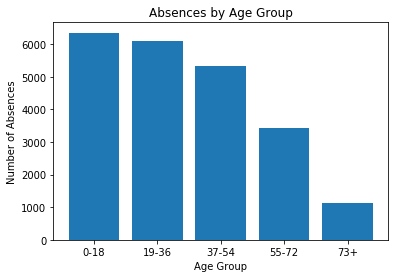

In [25]:
# Aggreggting all the absentees by their Age Group
absentByAge = absentdf.groupby("Age_Group")["Age_Group"].count()
locations = [1,2,3,4,5]
heights = absentByAge.values.tolist()

# Creating a bar chart
labels = ["0-18", "19-36", "37-54", "55-72", "73+"]
plt.bar(locations, heights, tick_label=labels)
plt.title('Absences by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Absences');

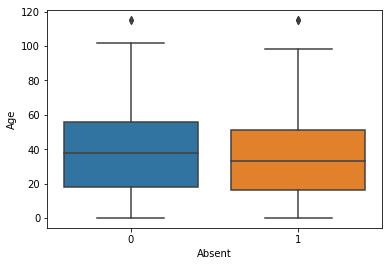

In [26]:
# Creating a boxplot to study distribution of Age
sns.boxplot(x="Absent", y="Age", data=df1)

#### Comments 
It seems that more absentees tend to be younger on average and the least absent age group are patients above 73 years old. However, this could be skewed by our age distribution of our records, which have fewer 73+ records than the records of the other groups. The other groups have a comparable number of records so even if we exclude 73+ years olds who have 3x less entries than the rest, the 55-72 group still has the fewest absences by far.

### Research Question 4 (Are people who receive SMS more or less absent than the ones who do not?)

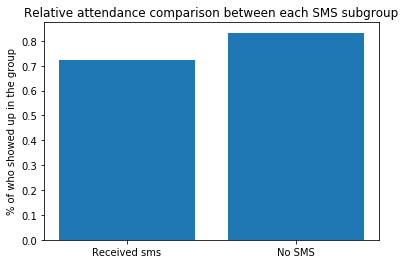

In [42]:
# Creating df of total distribution of SMS
totalSMSDistribution = df1.groupby("SMS_received")["SMS_received"].count()

# Total distribution of SMS splitted into two groups: Those who received SMS and those who did not
receivedSMS = totalSMSDistribution[1]
noSMS = totalSMSDistribution[0]

# To make a fair comparison, we need to compare attendace of each group relatively.
# Therefore, we need to separate the dataset into two groups:
# Those who received SMS and Showed Up
receivedSMSAndShowedUp = df1.query("SMS_received == 1  & Absent == 0")["PatientId"].count()
# Those who did not receive SMS and Showed Up
noSMSAndShowedUp = df1.query("SMS_received == 0  & Absent == 0")["PatientId"].count()

# From the numbers above, we can calculate relative attendance for each SMS subgroup
receivedSMSAndShowedUpRelative = receivedSMSAndShowedUp / receivedSMS
noSMSAndShowedUpRelative = noSMSAndShowedUp / noSMS

# Creating a bar chart with a relative attendance within each SMS subgroup
locations = [1,2]
heights = [receivedSMSAndShowedUpRelative, noSMSAndShowedUpRelative]
labels = ["Received sms", "No SMS"]
plt.bar(locations, heights, tick_label=labels)
plt.title('Relative attendance comparison between each SMS subgroup')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('% of who showed up in the group');

#### Comments
Relatively, 83.3% of the people who did not receive any SMS showed up compared to 72.4% of those who received SMS and showed up. This may indicate that whether patients received SMS or not did not have much of an effect on their attendance or even alternatively, it could have negative effect as the difference is more than 10% - We will explore more in the question 5

### Research Question 5 (What variables have the most impact on whether someone shows up or not?)
To answer that question we will use Logistic regression and run it in two ways using the following two packages:
<ol>
    <li>Scikit - For predicting Absence</li>
    <li>Statsmodels - For a more "stat" view and to get an overall model summary</li>
</ol>

In [27]:
# Taking a look at all the available variables
print(df1.keys())

# Creating a new df with columns that are relevant for Absence
# E.g. PatientID, AppointmentID, ScheduledDay most likely won´t have impact on whether someone is gonna show up or not
predictionDf = df1.iloc[:, [2,5,7,8,9,10,11,12,13]]

predictionDf.tail()

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Absent',
       'ScheduledDayOfWeek', 'AppointmentDayOfWeek', 'Age_Group'],
      dtype='object')


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Absent
110522,0,56,0,0,0,0,0,1,0
110523,0,51,0,0,0,0,0,1,0
110524,0,21,0,0,0,0,0,1,0
110525,0,38,0,0,0,0,0,1,0
110526,0,54,0,0,0,0,0,1,0


In [28]:
# Creating a df X containing all the features (Scholarship, Hipertension, Diabates, etc.) - Features
X = predictionDf.iloc[:,:-1]

# Creating a df Y containing only a predictor (Absent) - Target variable
Y = predictionDf["Absent"]

In [29]:
df1["Absent"].value_counts()

0    88207
1    22319
Name: Absent, dtype: int64

#### Comments
Our classes (Absent) are heavily imbalanced. This can significantly skew the end results of our model and predictions

In [31]:
# Split the data into 4 arrays X_train, Y_train, X_test, and Y_test. 
#  Where 70% of our entries will be train data and 30% test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_test.shape

(33158, 8)

#### Running the logistic regression using Scikit

In [32]:
# Creating a classifier (model)
classifier = LogisticRegression(solver='lbfgs',random_state=0)

# Tuning the classifier
results = classifier.fit(X_train, Y_train)
results

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
# Looking at the coefficients and intercept - Will interpret them in the part with Statsmodel
print(results.coef_)
print(results.intercept_)

[[-0.01981537 -0.00682406  0.20085129 -0.08090452  0.08736036  0.17582606
   0.03517306  0.65869571]]
[-1.37081855]


#### Comments
Notice that the intercepts and the coefficient is slightly different from the ones in the statsmodel (below).
That is because Scikit uses regularization which improves generalization performance, i.e., the performance on new, unseen data

In [34]:
# We test the classifier using the X_test array
predicted_y = classifier.predict(X_test)
predicted_y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [35]:
# Checking how accurate our model is
print('Accuracy: {:.2f}'.format(classifier.score(X_test, Y_test)))

Accuracy: 0.80


In [36]:
# Confusion Matrix
c1 = metrics.confusion_matrix(Y_test,predicted_y)
print(c1)

[[26565     0]
 [ 6593     0]]


#### Comments
<ul>
<li>True positive (TP): 26565 (We predicted that patient will not show up and patient originally did not show up)</li>
<li>True negative (TN): 0 (We predicted patient will show up and patient originally showed up)</li>
<li>False positive (FP): 6593 (We predicted patient will not show up and originally patient showed up)</li>
<li>False negative (FN): 0 (We predicted patients will show up but originally these patients did not show up)</li>
</ul>

In [37]:
#Evaluation matrices
from sklearn.metrics import precision_recall_fscore_support as score

#Accuracy = (TP+TN)/total, Accuracy= (26565+0)/= 26565/33158= 0.80= 80%
precision, recall, fscore, support = score(Y_test, predicted_y, average="micro")

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8011641232884975
recall: 0.8011641232884975
fscore: 0.8011641232884975
support: None


#### Comments
Precision can be intuitively understood as the classifier’s ability to only predict really positive samples as positive. 
Recall can be interpreted as the amount of positive test samples that were actually classified as positive.
F1 is just the weighted average between precision and recall. The higher precision and recall are, the higher the F1 score is. 
Source: https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/

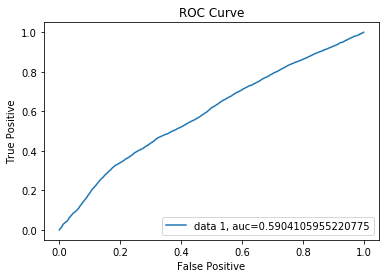

In [38]:
#ROC curve and AUC value
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel('False Positive')
plt.ylabel('True Positive');
plt.show()

#### Comments
The AUC value is 0.59 which is not that great. An AUC of 1 would be a perfect classifier and 0.5 is worthless as it means that our model is just a random prediction. 

#### Running the logistic regression using Statsmodel

In [39]:
# Importing statsmodel package
import statsmodels.api as sm

# Adding an intercept
X = sm.add_constant(X) ## let's add an intercept to our model

# Coducting the logit analysis using sm to get the result summary (scikit does not have it)
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.493036
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.020      
Dependent Variable: Absent           AIC:              109004.5946
Date:               2020-02-04 09:10 BIC:              109091.1116
No. Observations:   110526           Log-Likelihood:   -54493.    
Df Model:           8                LL-Null:          -55603.    
Df Residuals:       110517           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const         -1.3842    0.0176  -78.7178  0.0000  -1.4187  -1.3498
Gender        -0.0183    0.0163   -1.1208  0.2624

#### Comments
<ol>
    <li> Our model has an R-squared 0.02, which is really low. It means that this model explains 2% of the variance in our dependent variable (Absence). That means that it really does not fit very well and we would have to try different models (Decision Tree Classifier, Random Forest, etc.)</li>
    <li> The p-values for Gender, Hipertension (Borderline), Diabetes and Handcap are > 0.05, a common alpha level. That indicates that they are not statistically significant and in the next iteration we could remove them from the model.</li>
</ol>

In [40]:
# Calculating the odds ratios and outputting it with 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

                  2.5%     97.5%        OR
const         0.242028  0.259300  0.250515
Gender        0.951068  1.013759  0.981913
Age           0.992685  0.994214  0.993449
Scholarship   1.146045  1.261609  1.202439
Hipertension  0.890376  0.980449  0.934328
Diabetes      1.018424  1.164184  1.088868
Alcoholism    1.053700  1.255941  1.150385
Handcap       0.938978  1.135610  1.032624
SMS_received  1.858153  1.974329  1.915360


#### Takeaways (Hypothethical as the model does not really fit well)
<ol>  
 <li>The p-values for Gender, Hipertension (Borderline), Diabetes and Handcap are > 0.05, a common alpha level. That indicates that they are not statistically significant and in the next iteration we could remove them from the model. </li>  
 <li>For Age, the coefficient is -0.0183. This means that for every one-unit increase in Age, we expect a a 0.0183 decrease in the log-odds of the dependent variable Absent, holding all other variables constant</li>  
 <li>For Scholarship, the coefficient is 0.1844. This means that for every one-unit increase in Scholarship (in other words from having no scholarship to having it), we expect a a 0.1844 increase in the log-odds of the dependent variable Absent, holding all other variables constant. If we interpret this value via the Odds Ratio, for someone who has scholarship, the odds of Absence(Not showing up) are 1.202439 times higher than the odds for a non-scholar.</li>  
 <li> For every unit increase in Alcoholism (in other words from from having no Alcoholism to having it), we expect a 0.1401  increase in the log-odds of the dependent variable Absent, holding all other variables constant. If we interpret this value via the Odds Ratio, for someone who has Alcoholism, the odds of Absence(Not showing up) are 1.150385 higher than the odds for someone with no Alcoholism </li>
 <li> For every unit increase in SMS_Received (in other words from from having no SMS to having it), we expect a  0.6499 increase in the log-odds of the dependent variable Absent, holding all other variables constant. If we interpret this value via the Odds Ratio, for someone who received SMS, the odds of Absence(Not showing up) are 1.915360 times higher than the odds for someone who did not received SMS - This one is the most surprising as one would expect that if patient receives SMS, they are more likely to show up.</li>
</ol>  

<a id='conclusions'></a>
## Conclusions

#### During this analysis, we focused on answering 5 questions::
<ol>  
 <li> What neighborhoods have the most absences? </li>  
 <li> What days were the most appointments missed? </li>  
 <li> Which age groups (Young, Adults, etc.) have the most absences? </li>  
 <li> Are people who receive SMS are more or less absent than the ones who do not? </li>  
 <li> Which characteristics affect the likelihood of absence the most? By how much? </li>
</ol>  

##### 1. What neighbourhoods have the most absences?

We found out that the neighbourhood with the most absences are Jardum Camburi followed by Maria Ortiz and Itararé. A good future potential research question would be to identify if there are common variables that these neighborhoods share (Unemployment rate, Income, # of hospitals per capita, etc.)
LIMITATION: The record distribution across neighbourhoods varies quite a lot from 1 record per neighbourhood to 7K+

##### 2. What days were the most appointments missed?

The days with the most absences are  Mon-Wednesday, and the least missed appointments were on Saturday with 9 absences only.

##### 3. Which age groups (Young, Adults, etc.) have the most absences?

The group with the most absences is 0-18. The absentees tend to be younger on average and the least absent age group are patients above 73 years old. If we exclude the 73+ years group due to low number of records, the 55-72 years old are the next group with the least absences. 
LIMITATION: Age distribution among our patients in this dataset

##### 4. Are people who receive SMS are more or less absent than the ones who do not?

Relatively, 83.3% of the people who did not receive any SMS showed up compared to 72.4% of those who received SMS and showed up. This may indicate that whether patients received SMS or not did not have much of an effect on their attendance or even alternatively, it could have negative effect as the difference is more than 10% - We will explore more in the question 5

##### 5. Which characteristics affect the likelihood of absence the most? By how much?

Since our chosen model does not really fit well (R squared value of 0.02), we are unable to make any conclusion there as it would explain only 2% of the variance in our dependent variable. What the model at least partially supports though, are Q3 and Q4 as it suggests that the age and SMS received are statistically significant and are associated with the Absence:
<ul>
    <li> Older patients tend to be less absent </li>
    <li> Those who receive SMS are more likely to be absent</li>
</ul>

### Limitations

1) Source of data. There is no mention on kaggle about the source of the data. The person who uploaded the data said that it is confidential. Therefore, we dont know whether we can trust this data at all. This brings a multitude of questions such as: 

<ul>
    <li>Who collected the data?</li>
    <li>How was the data collected?</li>
    <li>What sampling methods were chosen?</li>
    <li>What are the different sources and their quality?</li>
    <li>How did the data collection process look like?</li>
</ul>

2) The Age of Data. The dataset contains data from 2016, which is almost 4 year ago. That is still reasonable and analysis from this dataset can serve as good indicators, but a lot can change in 4 years.


3) The characteristics that have impact on absence in this dataset are mostly health oriented. I hypothesize that there are other more important factors be it socioeconomic status (income, education, occupation etc.), waiting times, mental health, transportation options/availability/infrastructure, scheduling options (phone, online booking, email).

4) The distribution of the data collected is skewed across 
<ul>
    <li>Age: For 73+ years old patients, there are almost 3x less entries than every other age group.</li>
    <li>Gender: There are 2x more data points of women than men</li>
    <li>Absence: 4x less entries from no-shows(Absentees)</li>
    <li>SMS_received: 2x more data points from those who did not receive SMS </li>
</ul>
All of which definitely will affect the accuracy of my analysis.

To overcome these limitations, we could:
<ol>
    <li>Ask the kaggle uploader for information about the source of data to understand limitations in more detail.</li>
    <li>Adding other than mostly health related characteristics(Education, Socioeconomic Status, Transport options) would make the potential analysis much more comprehensive and reflective of the reality.</li>
    <li>Update the data so it includes years 2016 onwards. Then we could observe trends across time.</li>
    <li>Collect more samples so the distribution of Age, Gender, Absence, SMS_received and other characteristics are more even.</li>
</ol>

### Sources

<ol>
    <b> Data Cleaning, EDA & Visualisations </b>
    <li>https://medium.com/@purnasaigudikandula/exploratory-data-analysis-beginner-univariate-bivariate-and-multivariate-habberman-dataset-2365264b751</li> 
    <li>https://towardsdatascience.com/quick-dive-into-pandas-for-data-science-cc1c1a80d9c4</li>
    <li>https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf</li>
    <li>https://intellipaat.com/blog/tutorial/python-tutorial/numpy-cheat-sheet/</li>
    <li> https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html </li>
<ol>

<ol>
    <b> Logit Regression & Building model </b>
    <li>https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8</li> 
    <li>https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9</li>
    <li>https://towardsdatascience.com/logit-of-logistic-regression-understanding-the-fundamentals-f384152a33d1</li>
    <li>https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html</li>
    <li>https://www.statsmodels.org/stable/index.html</li>
    <li>https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin</li>
    <li> https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/ </li>
<ol>